# **Segmentation**
The code below illustrates the process of segmentation, e.g., splitting up a single image of a sequence of characters into mulltiple images of individual characters.

### **Imports**

In [1]:
import numpy as np
import cv2
import imutils
import matplotlib.pyplot as plt
from imutils import contours
import os
import glob

# For our classifiers
from sklearn.datasets import load_digits  
from sklearn import neighbors
import pickle

# For picture manipulation
from PIL import Image

from scipy import ndimage

import math

### **Helper Functions**
Each of these functions represent a functionality in the segmentation process. Not all are in use, but all have been tested. Once we switched to our own dataset we no longer needed dialation, blurring or closing since our challenge data directly matched the training data. 

In [2]:
IMAGE_PADDING = 4

def convert_to_grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def apply_gaussian_blur(img):
    return cv2.GaussianBlur(img, (3, 3), 1)

def apply_threshold(img):
    _, img = cv2.threshold(img, 120, 255, cv2.THRESH_BINARY_INV)
    return img

def dilate(img, rows=1, cols=1, i=1):
    return cv2.dilate(img, np.ones((rows, cols), np.uint8), iterations=i)

def close(img, rows=1, cols=1):
    return cv2.morphologyEx(img, cv2.MORPH_CLOSE, np.ones((rows, cols), np.uint8))

def get_contours(img, rows=1, cols=1):
    cnts, _ = cv2.findContours(img.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = contours.sort_contours(cnts, method="left-to-right")[0]
    return cnts

def get_characters(img, cnts):
    chars = []
    for cnt in cnts:
    
        # Bounding rect
        (x, y, w, h) = cv2.boundingRect(cnt)
        chars.append((x,y,w,h,img[y:y+h,x:x+w]))
        
    return np.asarray(chars)

def draw_contours(img, cnts):
    image = img.copy()
    for cnt in cnts:
        (x, y, w, h) = cv2.boundingRect(cnt)
        cv2.rectangle(image, (x, y), (x + w, y + h), (0,255,0), 3)
    plt.imshow(image, cmap='Greys_r')
    plt.show()        

def shape(img):
    
    h,w = img.shape
    aspect_ratio = w/h
    
    if aspect_ratio < 0.95:        
        padding = (h - w) // 2
        
        # Add width padding to create even aspect ratio
        img = cv2.copyMakeBorder(img,0,0,padding,padding,cv2.BORDER_CONSTANT,value=(0,0,0))
        
    elif aspect_ratio > 1.05:        
        padding = (w - h) // 2
        
         # Add width padding to create even aspect ratio
        img = cv2.copyMakeBorder(img,padding,padding,0,0,cv2.BORDER_CONSTANT,value=(0,0,0))
       
    # Resize
    img_size = 28 - IMAGE_PADDING * 2
    img = cv2.resize(img, (img_size, img_size))
    
    # add padding
    img = cv2.copyMakeBorder(img,IMAGE_PADDING,IMAGE_PADDING,IMAGE_PADDING,IMAGE_PADDING,cv2.BORDER_CONSTANT,value=(0,0,0))
    return img

## **Segmentation Process**

### (1) Load Image

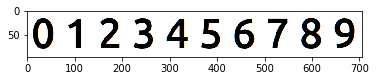

In [3]:
orig_img = cv2.imread("test.png")
plt.imshow(orig_img, cmap="Greys_r")
plt.show()

### (2) Convert to Grayscale
Images cannot be processed in RGB (0,0,0). So we convert the image from RGB to grayscale (0-1)

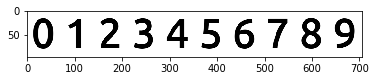

In [4]:
img = convert_to_grayscale(orig_img)
plt.imshow(img, cmap="Greys_r")
plt.show()

### (3) Apply Threshold
Basically inverting the image. This makes it easier for us to find the contours and classify.

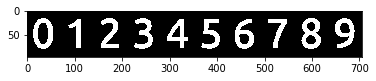

In [5]:
img = apply_threshold(img)
plt.imshow(img, cmap="Greys_r")
plt.show()

### (4) Contours

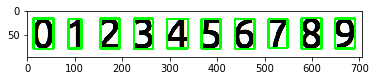

In [6]:
cnts = get_contours(img)
draw_contours(orig_img, cnts)

### (5) Reshaping Indiviudal Characters Method One**
Uses center of mass.

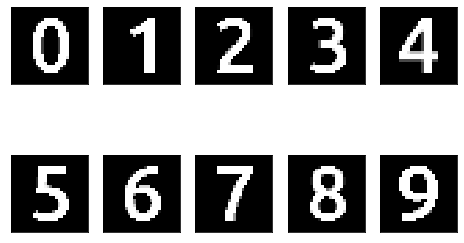

In [7]:
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(8, 5),
                        subplot_kw={'xticks': [], 'yticks': []})


# CREDIT: https://opensourc.es/blog/tensorflow-mnist
chars = get_characters(img, cnts)
resized_chars_1 = []
for ax, char in zip(axs.flat, chars):
    char_img = char[4]
    rows, cols = char_img.shape
    
    if rows > cols:
        factor = 20 / rows
        rows = 20
        cols = int(round(cols*factor))
        char_img = cv2.resize(char_img, (cols,rows))
    else:
        factor = 20.0/cols
        cols = 20
        rows = int(round(rows*factor))
        char_img = cv2.resize(char_img, (cols, rows))
        
    colsPadding = (int(math.ceil((28-cols)/2.0)),int(math.floor((28-cols)/2.0)))
    rowsPadding = (int(math.ceil((28-rows)/2.0)),int(math.floor((28-rows)/2.0)))
    char_img = np.lib.pad(char_img,(rowsPadding,colsPadding),'constant')
    resized_chars_1.append(char_img)
    ax.imshow(char_img, cmap="Greys_r")
    
reszied_chars_1 = np.asarray(resized_chars_1)

### (5) Reshaping Indiviudal Characters Method Two
Uses padding. This is the method in use currently on the website.

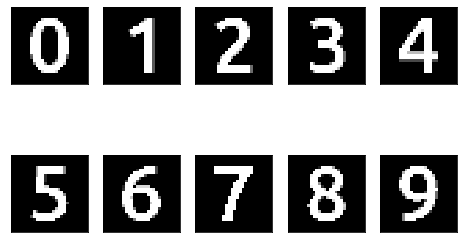

In [8]:
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(8, 5),
                        subplot_kw={'xticks': [], 'yticks': []})


chars = get_characters(img, cnts)
resized_chars_2 = []
for ax, char in zip(axs.flat, chars):
    char_img = char[4]
    char_img = shape(char_img)
    resized_chars_2.append(char_img)
    ax.imshow(char_img,cmap="Greys_r")
    
reszied_chars_2 = np.asarray(resized_chars_2)

## **Conclusion**

These techniques worked farily well for matching our challenge data with MNSIT (which has 3px padding) but had issues with the math dataset (no padding). Again, making our own dataset resolved this issues. Note, if the didgts are too close to one another, they will appear on the edges of the segmented images. This is fine. We are not trying to create a perfectg segmenter, we are just trying to get something to work.